In [21]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, ENGLISH_STOP_WORDS
from sklearn import decomposition
import numpy as np
import re
import nltk
from nltk.stem.porter import PorterStemmer
from sklearn.model_selection import train_test_split
import string
from collections import Counter
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

In [3]:
import warnings
pd.options.mode.chained_assignment = None
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
data_jpd = pd.read_json('data/JEOPARDY.json')
data_jpd['year'] = pd.DatetimeIndex(data_jpd['air_date']).year   # Get year
data_jpd['question'] = data_jpd['question'].str.replace('<a href=[^>]*>', '', regex=True)
# after observe the result, we decided to add the following stop words
data_jpd['question'] = data_jpd['question'].str.replace('Jimmy of the Clue Crew', '', regex=True)

In [32]:
data_jpd.head()

,category,air_date,question,value,answer,round,show_number,year
0,HISTORY,2004-12-31,"'For the last 8 years of his life, Galileo was...",$200,Copernicus,Jeopardy!,4680,2004
1,ESPN's TOP 10 ALL-TIME ATHLETES,2004-12-31,'No. 2: 1912 Olympian; football star at Carlis...,$200,Jim Thorpe,Jeopardy!,4680,2004
2,EVERYBODY TALKS ABOUT IT...,2004-12-31,'The city of Yuma in this state has a record a...,$200,Arizona,Jeopardy!,4680,2004
3,THE COMPANY LINE,2004-12-31,"'In 1963, live on ""The Art Linkletter Show"", t...",$200,McDonald\'s,Jeopardy!,4680,2004
4,EPITAPHS & TRIBUTES,2004-12-31,"'Signer of the Dec. of Indep., framer of the C...",$200,John Adams,Jeopardy!,4680,2004


In [33]:
data_jpd['round'].value_counts()

Jeopardy!           107384
Double Jeopardy!    105912
Final Jeopardy!       3631
Tiebreaker               3
Name: round, dtype: int64

In [4]:
def tokenize(text):
    """
    Tokenize text and return a non-unique list of tokenized words
    found in the text. Normalize to lowercase, strip punctuation,
    remove stop words, drop words of length < 3, strip digits.
    """
    text = text.lower()
    text = re.sub('[' + string.punctuation + '0-9\\r\\t\\n]', ' ', text)
    tokens = nltk.word_tokenize(text)
    tags = nltk.pos_tag(tokens)
    nouns = [word for word,pos in tags if (pos == 'NN' or pos == 'NNP' or pos == 'NNS' or pos == 'NNPS')]
    tokens = [w for w in nouns if len(w) > 2]
    tokens = [w for w in tokens if w not in ENGLISH_STOP_WORDS]
    return tokens

def stemwords(words):
    """
    Given a list of tokens/words, return a new list with each word
    stemmed using a PorterStemmer.
    """
    stemmer = PorterStemmer()
    stemmed_tokens = [stemmer.stem(word) for word in words]
    return stemmed_tokens

def tokenizer(text):
    return stemwords(tokenize(text))

In [5]:
def year_round_topic(round_name, year, n_components, num_word_in_topic):
    """Input: n_components = # of topics; 
              num_word_in_topic = words to describe the topic
       Output: unique_topic: Set of topics; 
               doc_topic= doc topic"""
    df = data_jpd[(data_jpd['round']==round_name) & ( data_jpd['year'] == year)]
    vectorizer = TfidfVectorizer(tokenizer=tokenize, max_df=0.75, max_features=1000, 
                                 lowercase=False, ngram_range=(1,2))
    tfidf_vectors = vectorizer.fit_transform(df['question'])
    
    nmf = decomposition.NMF(n_components=n_components)
    w1 = nmf.fit_transform(tfidf_vectors)
    h1 = nmf.components_
    
    vocab = np.array(vectorizer.get_feature_names())
    top_words = lambda x: [vocab[i] for i in np.argsort(x)[:-num_word_in_topic-1 :-1]]
    topic_words = [top_words(x) for x in h1]
    topics = [' '.join(t) for t in topic_words]
    # find the set of topic
    unique_topic = set()
    for n_topic in topic_words:
        for w in n_topic:
            unique_topic.add(w)
    # find the doc frequncy for each topic
    doc_topic = {}
    colnames = ["Topic" +str(i) for i in range(nmf.n_components)]
    docnames = ["Doc"+str(i) for i in range(len(df))]
    df_top_topic = pd.DataFrame(np.round(w1, 2), columns=colnames, index=docnames)
    top_topic = np.argmax(df_top_topic.values, axis=1)
    df_top_topic['top_topic'] = top_topic
    for i in range(n_components):
        doc_topic[topics[i]] = df_top_topic['top_topic'].value_counts()[i]
    
    return unique_topic, doc_topic

## Normal Jeopardy dominated topics by year

In [6]:
# Second printed item: Dictionary of how many questions are dominated 
# by topics related to the following words
jep_topic_words = []
years = data_jpd['year'].unique()
years.sort()

# Create dictionary to save the topic words ever year
year_dict_jeop = {year: None for year in years}

for year in sorted(data_jpd['year'].unique()):
    uniques, _ = year_round_topic('Jeopardy!', year, 4, 6)
    jep_topic_words.extend(list(uniques))
    year_dict_jeop[year] = list(uniques)

# Count the occurences to get a general idea of topics across years
jep_counter = Counter(jep_topic_words)


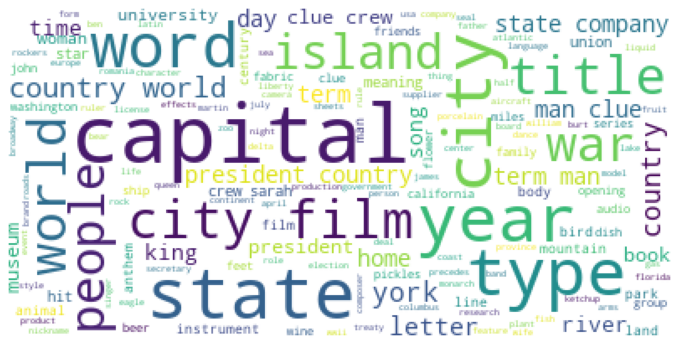

In [35]:
wordcloud = WordCloud(max_font_size=50, max_words=150, background_color="white").generate((" ").join(jep_topic_words))
plt.figure(figsize=(12,8))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

In [20]:
# Second printed item: Dictionary of how many questions are dominated 
# by topics related to the following words
keywords, doc_by_topic = year_round_topic('Jeopardy!',1998, 4, 5)
print(f'The dominated topics for 1998 is {keywords}, \n\nThe questions distribution is {doc_by_topic}')

The dominated topics for 1998 is {'country', 'years', 'way', 'title', 'state', 'type', 'capital', 'museum', 'river', 'term', 'liquor', 'oscar', 'city', 'film', 'man', 'people', 'island'}, 

The questions distribution is {'country man state island river': 4362, 'film title man oscar years': 1134, 'city capital museum state people': 746, 'type term years liquor way': 286}


In [34]:
second_round = []
for year in sorted(data_jpd['year'].unique()):
    uniques, _ = year_round_topic('Double Jeopardy!', year, 4, 6)
    second_round.extend(list(uniques))

/Users/lolu/opt/anaconda3/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1090: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"
/Users/lolu/opt/anaconda3/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1090: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


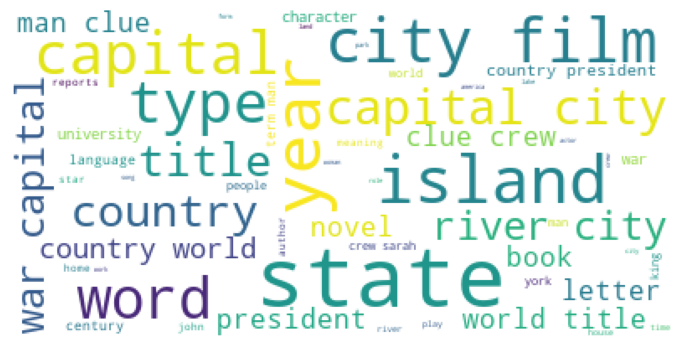

In [41]:
wordcloud = WordCloud(max_font_size=50, max_words=150, background_color="white").generate((" ").join(second_round))
plt.figure(figsize=(12,8))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

## Final Jeopardy

In [37]:
final_round = []
for year in sorted(data_jpd['year'].unique()):
    uniques, _ = year_round_topic('Final Jeopardy!', year, 4, 6)
    final_round.extend(list(uniques))

/Users/lolu/opt/anaconda3/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1090: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"
/Users/lolu/opt/anaconda3/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1090: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"
/Users/lolu/opt/anaconda3/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1090: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"
/Users/lolu/opt/anaconda3/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1090: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum n

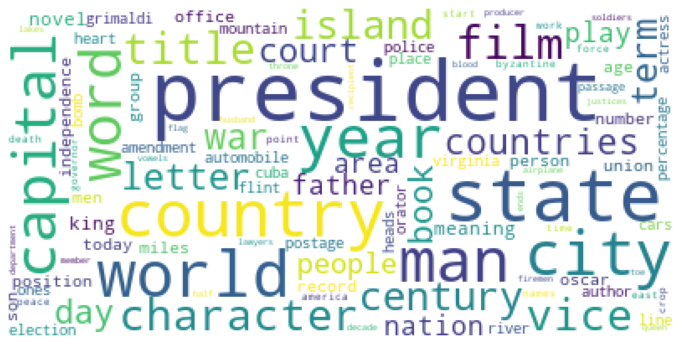

In [38]:
wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate((" ").join(final_round))
plt.figure(figsize=(12,8))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

In [60]:
for year in sorted(data_jpd['year'].unique()):
    uniques, question_counts = year_round_topic('Final Jeopardy!', year, 4, 6)
    print(question_counts)

{'amendment years amendment years election years decade decade amendment': 12, 'country year country cars cars cars year freedom': 3, 'president automobile airplane airplane president automobile automobile number': 2, 'starting monday starting monday continents olympic continents olympic': 6}
{'president president recognition china recognition recognition china president court': 3, 'states words dakotas carolinas words names words carolinas carolinas states': 3, 'americas capital americas capital recipient group group recipient': 6, 'exchange companies fortune stock companies stock exchange stock companies state': 4}
{'country country soldiers soldiers world world country producer world': 11, 'president lawyers president lawyers year wife president husband queen': 3, 'number toe number tac toe number board toe board': 2, 'corporation profit corporation cabinet profit cabinet profit agency cabinet': 8}
{'island flag island flag miles island miles island mediterranean': 6, 'state preside

/Users/zixiluo/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1077: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


{'life imprisonment books struggle life struggle walk walk struggle': 26, 'world capital elevation feet world feet feet elevation': 5, 'age abbey abbey kykkos age novice novice abbey kykkos': 2, 'glass town flint flint glass brooklyn brooklyn flint': 2}
{'title play play boy title role role boy': 8, 'war world age age war world war europe': 3, 'word machine word machine verdi opera england england century': 2, 'election presidency republican presidency republican presidency office office election': 6}
{'president jacques jacques chirac chirac chirac president president republic': 5, 'house presidents house presidents house congress party congress party': 4, 'isotope fireworks isotope fireworks mass fireworks mass isotope fallout': 4, 'end declaration end declaration things end things event': 6}
{'vice vice president president republicans vice republicans mentor': 56, 'country world country world people world people democracy': 3, 'city capital city byzantine benjamin franklin church by

In [61]:
# Sort the dictionary to find the top words that occcur across years
counter = {k: v for k, v in sorted(counter.items(), key=lambda item: item[1], reverse=True)}
top_topics = {}
# Get top 8 topics from the sorted list of most common word across all years
for i, (k, v) in enumerate(counter.items()):
    top_topics[k] = v

In [62]:
# find distributions of the top k most popular topics across years
# Potentially create stacked bar; color for each topic
year_occurences = {year:0 for year in years}
# Check vice-versa - for each topic, see which years 
topic_occurences = {topic: [] for topic in top_topics}
for topic in top_topics.keys():
    for year, values in year_dict.items():
        if topic in values:
            year_occurences[year] +=1
            topic_occurences[topic].append(year)

In [65]:
top_topics

{'president': 20,
 'country': 19,
 'state': 17,
 'man': 17,
 'world': 15,
 'years': 12,
 'city': 12,
 'word': 11,
 'capital': 11}

## See how dominated topics changed by values of each questions

In [66]:
def value_round_topic(round_name, value, n_components, num_word_in_topic):
    """Input: n_components = # of topics; num_word_in_topic = words to describe the topic
    Output: unique_topic: Set of topics; doc_topic= doc topic"""
    df = data_jpd[(data_jpd['round']==round_name) & ( data_jpd['value'] == value)]
    vectorizer = TfidfVectorizer(tokenizer=tokenize, max_df=0.75, max_features=1000, 
                                 lowercase=False, ngram_range=(1,2))
    tfidf_vectors = vectorizer.fit_transform(df['question'])
    
    nmf = decomposition.NMF(n_components=n_components)
    w1 = nmf.fit_transform(tfidf_vectors)
    h1 = nmf.components_
    
    vocab = np.array(vectorizer.get_feature_names())
    top_words = lambda x: [vocab[i] for i in np.argsort(x)[:-num_word_in_topic-1 :-1]]
    topic_words = [top_words(x) for x in h1]
    topics = [' '.join(t) for t in topic_words]
    # find the set of topic
    unique_topic = set()
    for n_topic in topic_words:
        for w in n_topic:
            unique_topic.add(w)
    # find the doc frequncy for each topic
    doc_topic = {}
    colnames = ["Topic" +str(i) for i in range(nmf.n_components)]
    docnames = ["Doc"+str(i) for i in range(len(df))]
    df_top_topic = pd.DataFrame(np.round(w1, 2), columns=colnames, index=docnames)
    top_topic = np.argmax(df_top_topic.values, axis=1)
    df_top_topic['top_topic'] = top_topic
    for i in range(n_components):
        doc_topic[topics[i]] = df_top_topic['top_topic'].value_counts()[i]
    
    return unique_topic, doc_topic

In [67]:
# There is a '$1,000' and a '$1000' so we need to align the values
# print(len(data_jpd[data_jpd['value']=='$1,000']), len(data_jpd[data_jpd['value']== '$1000']))
data_jpd['value'] = data_jpd['value'].replace(['$1,000'], '$1000')
# print(len(data_jpd[data_jpd['value']=='$1,000']), len(data_jpd[data_jpd['value']== '$1000']))

# There is a '$1,000' and a '$1000' so we need to align the values
# print(len(data_jpd[data_jpd['value']=='$2,000']), len(data_jpd[data_jpd['value']== '$2000']))
data_jpd['value'] = data_jpd['value'].replace(['$2,000'], '$2000')
# print(len(data_jpd[data_jpd['value']=='$2,000']), len(data_jpd[data_jpd['value']== '$2000']))

In [68]:
jeopardy_prizes = ['$200', '$400', '$600', '$800', '$1000']
jeopardy_2_prizes = ['$400', '$800', '$1200', '$1600', '$2000']

In [69]:
def is_substring(set_a):
    list_a = sorted(list(set_a))
    for w in list_a:
        temp = list_a
        temp.remove(w)
        if [w] in [s.split() for s in temp]:
            list_a = temp
    return list_a

In [70]:
def money_round_topic(round_name, money, n_components, num_word_in_topic):
    df = data_jpd[(data_jpd['round']==round_name) & ( data_jpd['value'] == money)]
    vectorizer = TfidfVectorizer(tokenizer=tokenize, max_df=0.75, max_features=1000, 
                                 lowercase=False, ngram_range=(1,2))
    tfidf_vectors = vectorizer.fit_transform(df['question'])
    
    nmf = decomposition.NMF(n_components=n_components)
    w1 = nmf.fit_transform(tfidf_vectors)
    h1 = nmf.components_
    
    vocab = np.array(vectorizer.get_feature_names())
    top_words = lambda x: [vocab[i] for i in np.argsort(x)[:-num_word_in_topic-1 :-1]]
    topic_words = [top_words(x) for x in h1]
    topics = [' '.join(t) for t in topic_words]
    # find the set of topic
    unique_topic = set()
    for n_topic in topic_words:
        for w in n_topic:
            unique_topic.add(w)
    # find the doc frequncy for each topic
    doc_topic = {}
    colnames = ["Topic" +str(i) for i in range(nmf.n_components)]
    docnames = ["Doc"+str(i) for i in range(len(df))]
    df_top_topic = pd.DataFrame(np.round(w1, 2), columns=colnames, index=docnames)
    top_topic = np.argmax(df_top_topic.values, axis=1)
    df_top_topic['top_topic'] = top_topic
    for i in range(n_components):
        doc_topic[topics[i]] = df_top_topic['top_topic'].value_counts()[i]
    
    return is_substring(unique_topic), doc_topic

In [71]:
for m in jeopardy_prizes:
    print(m, money_round_topic('Jeopardy!', m, 4, 10))
    print()

$200 (['capital', 'city', 'day', 'flag', 'island', 'miles', 'park', 'president', 'state', 'time', 'type', 'university', 'word', 'year', 'york'], {'city capital world capital city york york city people home museum war': 15408, 'country world president people war years island capital year miles': 1361, 'state capital park president state capital area river university union flag': 853, 'man type film president years time day title word year': 3968})

$400 (['book', 'capital city', 'clue', 'film', 'island', 'museum', 'people', 'river', 'song', 'state capital', 'time', 'university', 'word', 'year', 'york'], {'city capital world home capital city york people river museum site': 16721, 'country world war island years man president people year word': 1526, 'state man capital park home song river state capital film university': 1495, 'type bird word man term time world book clue film': 1214})

$600 (['capital', 'clue', 'company', 'crew', 'film', 'island', 'letter word', 'novel', 'president', 'r

In [72]:
for m in jeopardy_2_prizes:
    print(m, value_round_topic('Double Jeopardy!', m, 4, 10))
    print()

$400 ({'city', 'novel', 'world', 'man', 'film', 'woman', 'letter', 'number', 'bird', 'title', 'capital city', 'year', 'state', 'king', 'work', 'home', 'capital', 'york city', 'term', 'york', 'book', 'river', 'people', 'president', 'time', 'war', 'country', 'years', 'type', 'word', 'island'}, {'country president world years war state capital island king year': 15722, 'city capital state capital city river york york city world home people': 2064, 'man film president title word year time woman state novel': 2429, 'type word term title work film bird letter number book': 1073})

$800 ({'city', 'novel', 'crew', 'world', 'man', 'film', 'author', 'letter', 'bird', 'title', 'capital city', 'clue', 'language', 'university', 'year', 'state', 'king', 'work', 'home', 'capital', 'york city', 'term', 'york', 'river', 'people', 'president', 'war', 'century', 'country', 'years', 'type', 'word', 'island'}, {'city capital state world river york home capital city york city university': 13955, 'country pr

/Users/zixiluo/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1077: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


$1200 ({'company', 'creature', 'city', 'crew', 'form', 'sarah', 'man', 'plant', 'film', 'author', 'woman', 'letter', 'title', 'crew reports', 'water', 'clue crew', 'clue', 'state', 'king', 'home', 'capital', 'cheryl clue', 'term', 'book', 'river', 'sarah clue', 'people', 'president', 'time', 'cheryl', 'war', 'reports', 'country', 'years', 'type', 'word'}, {'country city capital state president king home years river war': 7208, 'man film title president time woman book word term author': 1795, 'clue crew clue crew city sarah sarah clue reports crew reports cheryl cheryl clue': 1890, 'type word term letter people creature form water plant company': 438})

$1600 ({'city', 'crew', 'sarah', 'world', 'man', 'film', 'author', 'woman', 'life', 'letter', 'word term', 'title', 'capital city', 'clue crew', 'clue', 'state', 'king', 'home', 'capital', 'phrase', 'word meaning', 'term', 'latin', 'book', 'river', 'meaning', 'sarah clue', 'president', 'war', 'country', 'years', 'type', 'letter word', '

In [73]:
def year_money_round_topic(round_name, money, year, n_components, num_word_in_topic):
    df = data_jpd[(data_jpd['round']==round_name) & (data_jpd['value'] == money) & (data_jpd['year'] == year)]
    if len(df) < 5 :
        return "combination not exist or too small!"
    else:
        vectorizer = TfidfVectorizer(tokenizer=tokenize, max_df=0.75, max_features=1000, 
                                     lowercase=False, ngram_range=(1,2))
        tfidf_vectors = vectorizer.fit_transform(df['question'])

        nmf = decomposition.NMF(n_components=n_components)
        w1 = nmf.fit_transform(tfidf_vectors)
        h1 = nmf.components_

        vocab = np.array(vectorizer.get_feature_names())
        top_words = lambda x: [vocab[i] for i in np.argsort(x)[:-num_word_in_topic-1 :-1]]
        topic_words = [top_words(x) for x in h1]
        topics = [' '.join(t) for t in topic_words]
        # find the set of topic
        unique_topic = set()
        for n_topic in topic_words:
            for w in n_topic:
                unique_topic.add(w)
        # find the doc frequncy for each topic
        doc_topic = {}
        colnames = ["Topic" +str(i) for i in range(nmf.n_components)]
        docnames = ["Doc"+str(i) for i in range(len(df))]
        df_top_topic = pd.DataFrame(np.round(w1, 2), columns=colnames, index=docnames)
        top_topic = np.argmax(df_top_topic.values, axis=1)
        df_top_topic['top_topic'] = top_topic
        for i in range(n_components):
            doc_topic[topics[i]] = df_top_topic['top_topic'].value_counts()[i]

        return is_substring(unique_topic), doc_topic

In [74]:
for m in jeopardy_prizes:
    for year in sorted(data_jpd['year'].unique()):
        print(m, year, year_money_round_topic('Jeopardy!', m, year, 4, 5))
        print()

$200 1984 (['chess', 'color chess', 'flag', 'harbor war', 'lincoln', 'logs', 'mare', 'ones', 'war', 'years versailles'], {'years years versailles versailles logs forest logs': 96, 'color flag color flag color chess chess': 14, 'age mare mare age horse ones': 2, 'war lincoln harbor war harbor lincoln book': 13})

$200 1985 (['diamond', 'higgins', 'letter', 'letter location', 'movie', 'phrase', 'role film', 'state', 'wine', 'year'], {'movie year character phrase star': 83, 'state wine wine state state nation nation': 2, 'film role higgins higgins role role film': 4, 'letter location letter location letter designation diamond': 2})

$200 1986 (['cake', 'death', 'food', 'habits', 'sign', 'stars', 'state', 'symbol', 'time', 'way'], {'symbol stars stars symbol sign symbol sign': 115, 'city death cake state state city': 15, 'way spain habits habits way asparagus': 7, 'time food food time film time baby': 7})

$200 1987 (['building', 'country', 'flower', 'fungo', 'god', 'life country', 'people

/Users/zixiluo/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1077: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)
/Users/zixiluo/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1077: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


$200 1988 (['animals star', 'country', 'cowboy', 'gait', 'king', 'legs', 'movie', 'queen', 'star', 'woman'], {'type land legs gait legs gait': 90, 'star cowboy woman animals animals star': 18, 'country queen country noblewoman noblewoman queen country': 8, 'movie city man king death wish': 10})

$200 1989 (['book electrons', 'city', 'continent', 'country slavery', 'line', 'sea', 'states', 'war', 'women', 'world glacier'], {'country country slavery slavery priest women': 129, 'city city states states war capital': 28, 'world continent world glacier book book electrons': 26, 'line day way sea time': 19})

$200 1990 (['birds', 'city', 'country', 'diamond', 'film', 'king', 'mates day', 'people', 'way'], {'king art england colony diamond': 226, 'city california joseph film napoleon': 84, 'country state people colony diamond': 75, 'day birds way mates day mates': 39})

$200 1991 (['bird welsh', 'city city', 'city world', 'head', 'man', 'practice', 'type', 'welsh head', 'wine hails', 'world']

/Users/zixiluo/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1077: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


$200 1995 (['animals phrase', 'campers', 'capital city', 'coins', 'country', 'monument', 'river', 'star', 'statue liberty', 'time campers'], {'time campers time campers series star': 72, 'city capital capital city monument brzezinski capital': 20, 'animals phrase animals phrase land river': 2, 'coins country coins statue statue liberty statue': 17})

$200 1996 (['capital', 'city', 'day', 'father', 'lake', 'mayor', 'series', 'state', 'title'], {'city capital capital city father mayor': 285, 'title man throne father comedy': 39, 'star film series book day': 109, 'state river lake days week': 52})

$200 1997 (['city', 'england', 'group', 'henry', 'president', 'state', 'time', 'type', 'woman'], {'country time world type president': 735, 'film henry star woman title': 160, 'city war capital england world': 226, 'term state group head number': 168})

$200 1998 (['capital', 'country', 'museum', 'people', 'president', 'star', 'states', 'type', 'years'], {'country people people country year riv

/Users/zixiluo/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1077: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


$400 1988 (['bellows squeezebox', 'dance', 'folds', 'leaf thing', 'restaurant', 'song range', 'state', 'term', 'thing', 'word'], {'term body word term telegram telegram': 85, 'fabric folds bellows bellows squeezebox squeezebox': 2, 'state song party dance song range': 13, 'thing leaf leaf thing restaurant thing restaurant': 15})

$400 1989 (['album jordan', 'city', 'film', 'line', 'oscar', 'pike', 'porcelain', 'president hoover', 'son', 'wilde'], {'john album son album jordan line': 150, 'president building president hoover president johnson vice': 10, 'city porcelain pike pike pickerel city pike': 14, 'film oscar man oscar wilde wilde': 21})

$400 1990 (['book', 'capital', 'city', 'country', 'home', 'island', 'ones', 'state', 'war', 'years'], {'country years candidate independence war': 291, 'city capital home city home capital city': 57, 'animals book wife ones ocean benthos': 24, 'island state state anniversary group park': 27})

$400 1991 (['actor star', 'columbus', 'harvard', 'mag

/Users/zixiluo/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1077: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


$400 1992 (['bob', 'ceausescu', 'city', 'country', 'father', 'king', 'people', 'state', 'title', 'type antelope'], {'country ceausescu ceausescu dictator bob country language': 124, 'state city people state fossil colorado': 16, 'king book title father persia': 23, 'type john paul type antelope antelope': 18})

$400 1993 (['balloon flight', 'city', 'counties country', 'horse', 'newspaper', 'parishes state', 'photos book', 'state', 'territory', 'world'], {'city balloon balloon flight river january': 140, 'country word counties counties country territory': 23, 'state newspaper parishes state parishes state newspaper': 24, 'book world horse photos book photos': 17})

$400 1994 (['capital', 'company', 'days', 'minutes', 'mountain', 'museum', 'novel women', 'paper towel', 'women', 'year passover'], {'city mountain mountain city capital museum': 88, 'man minutes novel women novel women': 9, 'company paper towel company paper paper phildelphia': 3, 'days year mother year passover bread': 7})


/Users/zixiluo/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1077: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


$400 1995 (['country', 'days', 'games', 'gehrig record', 'man', 'mexico operation', 'operation state', 'shirley', 'state', 'trophy time'], {'time country trophy time country trophy july country': 83, 'city days shirley days shirley shirley city': 8, 'state mexico operation state mexico operation operation': 10, 'record man gehrig record gehrig games': 9})

$400 1996 (['country', 'end', 'mosquito state', 'pompeii', 'ruler', 'state', 'type', 'type cutex', 'type writing', 'year'], {'city river minutes pompeii norway city': 284, 'country cuisine end ruler street': 72, 'state year university south mosquito state': 60, 'type type writing type fabric type cutex type aircraft': 37})

$400 1997 (['boat', 'city', 'film', 'lake', 'place', 'state', 'type', 'word', 'years', 'york city'], {'type boat word type material material': 551, 'city york christmas york city site': 166, 'country america world years lake': 192, 'state home film state home place': 335})

$400 1998 (['area', 'country', 'film', '

/Users/zixiluo/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1077: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


$800 1984 combination not exist or too small!

$800 1985 combination not exist or too small!

$800 1986 combination not exist or too small!

$800 1987 combination not exist or too small!

$800 1988 combination not exist or too small!

$800 1989 combination not exist or too small!

$800 1990 combination not exist or too small!

$800 1991 combination not exist or too small!

$800 1992 combination not exist or too small!

$800 1993 combination not exist or too small!

$800 1994 combination not exist or too small!

$800 1995 combination not exist or too small!

$800 1996 (['body', 'country court', 'court legislature', 'dog body', 'films life', 'life', 'rachel', 'shepherd', 'shepherdess shepherd', 'vertebrae dog'], {'country legislature country court court court legislature': 2, 'amour films films life life amour life': 1, 'vertebrae dog vertebrae body dog body dog': 1, 'rachel shepherdess shepherd shepherdess shepherd rachel shepherdess': 1})

$800 1997 (['angels', 'case sept', 'city group

/Users/zixiluo/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1077: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


$800 2001 (['army camp', 'camp', 'city', 'congress', 'heavyweight', 'june', 'president', 'title', 'tree art', 'war'], {'champ heavyweight heavyweight champ title sons': 69, 'city camp army city army army camp': 9, 'congress president person june war': 10, 'tree art film tree art type': 14})

$800 2002 (['cheryl', 'city', 'clue crew', 'crew', 'film', 'heard', 'road', 'star', 'type', 'years'], {'type fruit senators john road': 309, 'film star heard term death': 156, 'city world years capital country': 138, 'clue clue crew crew cheryl cheryl clue': 41})

$800 2003 (['capital', 'city', 'clue crew', 'couple', 'end', 'island', 'praises', 'series', 'title', 'woman'], {'city state country river capital': 536, 'man woman film end couple': 97, 'type clue clue crew crew island': 161, 'book title series character praises': 82})

$800 2004 (['book', 'city', 'clue crew', 'country', 'film', 'history', 'men', 'park', 'title'], {'state nation history world men': 446, 'man book company army guy': 121, '

/Users/zixiluo/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1077: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


$1000 1984 combination not exist or too small!

$1000 1985 combination not exist or too small!

$1000 1986 combination not exist or too small!

$1000 1987 combination not exist or too small!

$1000 1988 combination not exist or too small!

$1000 1989 (['days', 'exodus things', 'gentlemen peace', 'neighbor', 'peace peace', 'record college', 'synonym', 'term', 'things'], {'hit song record college record college': 2, 'things neighbor things exodus exodus things neighbor': 1, 'peace peace peace gentlemen peace gentlemen things neighbor': 1, 'days term days term synonym term synonym': 1})

$1000 1990 (['braddock', 'businessman', 'epoch period', 'grace king', 'holocene epoch', 'library', 'lord', 'movies trio', 'series movies', 'trio mills'], {'lord king lord ireland grace king grace': 2, 'library businessman library braddock braddock library businessman': 1, 'series movies aunt movies trio trio mills trio': 3, 'period holocene holocene epoch epoch period epoch': 1})

$1000 1991 (['angel brea

/Users/zixiluo/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1077: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


In [75]:
for m in jeopardy_2_prizes:
    for year in sorted(data_jpd['year'].unique()):
        print(m, year, year_money_round_topic('Double Jeopardy!', m, year, 4, 5))
        print()

$400 1984 (['continent', 'form', 'function', 'greek', 'home buckeyes', 'minotaur', 'pieces', 'population country', 'world', 'wurlitzer pride'], {'form greek form greek wurlitzer wurlitzer pride': 101, 'country population war continent population country': 11, 'people world function people function pieces': 7, 'home minotaur home buckeyes home minotaur buckeyes': 4})

$400 1985 (['america', 'cherokee', 'city banks', 'genesis', 'pictures radio', 'radio', 'state', 'studebakers city', 'way', 'word times'], {'city studebakers studebakers city river city banks': 74, 'way word times word times genesis': 7, 'state america america state advocate paper cherokee': 3, 'radio pictures radio pictures program film': 6})

$400 1986 (['city governor', 'country country', 'gonzo', 'governor mile', 'henry', 'leader', 'letters', 'movie', 'role', 'year'], {'country leader leader country war country country': 113, 'city mile city governor governor mile governor': 7, 'role movie movie role fife gonzo': 4, 'ye

/Users/zixiluo/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1077: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


$400 1988 (['bowl', 'department', 'film', 'music', 'novel', 'pumpkin shell', 'store', 'war', 'wars country', 'wife pumpkin'], {'country war war country america wars country': 84, 'man music music man novel film': 21, 'department department store store texas bowl': 9, 'wife pumpkin shell pumpkin shell wife pumpkin': 5})

$400 1989 (['city', 'country', 'film', 'instrument', 'lips', 'petersburg', 'shell', 'state license', 'tree', 'way brass'], {'city city dance dance petersburg petersburg city': 137, 'island country film group capital': 24, 'way lips instrument way brass shell': 10, 'state state license state tree tree nickname': 34})

$400 1990 (['brazil', 'capital city', 'city', 'daughter', 'god', 'john', 'life', 'pioneer artist', 'title', 'work'], {'city capital capital city brazil airport': 249, 'country daughter neutrality god lakme': 21, 'president war governor life pioneer artist': 44, 'john film title work character': 100})

$400 1991 (['city', 'country', 'haberdashery', 'island',

/Users/zixiluo/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1077: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)
/Users/zixiluo/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1077: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


$800 1988 (['border', 'city', 'land', 'paso city', 'president', 'roman', 'schoolmaster politics', 'state', 'wife', 'york'], {'city border paso paso city city border': 79, 'state war land york battle': 20, 'president century president century politics schoolmaster politics': 3, 'wife son roman roman wife wife messalina': 17})

$800 1989 (['commodore', 'country higgins', 'hero', 'island', 'kills', 'line', 'mcdowall', 'novel eternity', 'star title', 'years'], {'country years country higgins commodore acquisition': 111, 'man line novel eternity novel jesus': 18, 'island kills island kills father house': 34, 'title hero number star title mcdowall': 10})

$800 1990 (['capital', 'coast', 'death', 'home', 'king', 'nickname', 'psamtik assyrians', 'spain', 'variety'], {'state energy capital home nickname': 209, 'city river port league island': 44, 'death king spain variety years': 94, 'country coast alphabet island psamtik assyrians': 20})

$800 1991 (['beaches', 'city', 'country', 'country coun

/Users/zixiluo/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1077: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


$800 1992 (['capital city', 'century jean', 'city', 'decree', 'emperor', 'jean', 'organs', 'people', 'times', 'world'], {'capital city capital city church paintings church': 103, 'emperor world decree world decree people': 10, 'country james war times pulitzer': 41, 'organs century jean century jean jean fontaine': 7})

$800 1993 (['century', 'country', 'fruit', 'man', 'mines gold', 'minister country', 'pearl', 'refers lexington', 'term', 'tooth'], {'country minister country kingdom minister country fruit': 97, 'state mountain gold mines mines gold': 19, 'term man president tooth term tooth': 35, 'capital century city pearl refers lexington': 34})

$800 1994 (['capital', 'city', 'disease', 'hari', 'lake', 'mata hari', 'park', 'river', 'title character', 'university arizona'], {'character title title character novel frances hodgson': 60, 'city university capital arizona university arizona': 18, 'country park hari country hari mata hari': 5, 'river disease power lake lake river': 11})



/Users/zixiluo/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1077: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


$800 1995 (['century', 'city country', 'country europe', 'hawk', 'king', 'language lett', 'lett', 'play king', 'war', 'women'], {'country europe country europe city city country': 73, 'king play play king century women': 18, 'language lett language lett language status status': 2, 'war war hawk hawk hawk war carolina war': 2})

$800 1996 (['capital', 'country', 'fact', 'independence country', 'king', 'liqueur', 'oil', 'war', 'year', 'years exile'], {'country independence language element independence country': 219, 'city war year fact oil': 68, 'years author president king years exile': 93, 'capital island liqueur ocean word': 40})

$800 1997 (['book', 'city', 'film', 'lake', 'man', 'play', 'republic', 'state', 'word', 'years'], {'country world area lake republic': 423, 'man title president school law': 149, 'film book word oscar play': 281, 'city capital state group years': 269})

$800 1998 (['capital', 'city', 'film', 'man', 'people', 'president', 'term', 'title', 'word', 'world'], {

/Users/zixiluo/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1077: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


$2000 1992 (['autobiography', 'capital', 'christiania', 'cousin rachel', 'day day', 'destroyed capital', 'rachel', 'term', 'time', 'walter'], {'autobiography time autobiography time rachel cousin rachel': 3, 'day term day day term day friedman place': 3, 'afl walter cio reuther union': 1, 'christiania capital christiania destroyed capital destroyed capital': 5})

$2000 1993 (['fables panchatantra', 'language', 'life macomber', 'macomber magazine', 'market', 'money farmers', 'panchatantra', 'party', 'scholarship', 'senator monopolization'], {'language panchatantra language fables fables panchatantra panchatantra': 12, 'life macomber magazine macomber life macomber magazine': 2, 'party party money money farmers money farmers': 2, 'scholarship senator market senator monopolization ohio': 2})

$2000 1994 (['bestselling novel', 'children corner', 'company steel', 'custom flag', 'lessons', 'paris', 'steel', 'suite', 'tomb'], {'steel steel company company steel company tomb paris': 2, 'tomb p

/Users/zixiluo/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1077: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


# Normal Jeopardy Values

In [76]:
# Normal Jeopardy Values
topic_words_2a = []
dict_2a = {value: None for value in jeopardy_prizes}

for value in jeopardy_prizes:
    uniques, _ = money_round_topic('Jeopardy!', value, 4, 10)
    print(value, uniques)
    print()
    topic_words_2a.extend(list(uniques))
    dict_2a[value] = list(uniques)

counter_2a = Counter(topic_words_2a)

$200 ['capital', 'city', 'day', 'flag', 'island', 'miles', 'park', 'president', 'state', 'time', 'type', 'university', 'word', 'year', 'york']

$400 ['book', 'capital city', 'clue', 'film', 'island', 'museum', 'people', 'river', 'song', 'state capital', 'time', 'university', 'word', 'year', 'york']

$600 ['capital', 'clue', 'company', 'crew', 'film', 'island', 'letter word', 'novel', 'president', 'river', 'state', 'time', 'type', 'war', 'world', 'years']

$800 ['capital', 'clue', 'company', 'crew', 'film', 'island', 'letter', 'man', 'park', 'reports', 'sarah', 'sea', 'state', 'title', 'war', 'word', 'word term', 'years']

$1000 ['capital city', 'clue', 'country', 'fish', 'home', 'letter', 'man', 'president', 'sarah', 'state', 'title', 'university', 'water', 'world', 'years', 'york city']



In [77]:
# Sort the dictionary to find the top words that occcur across years
counter_2a = {k: v for k, v in sorted(counter_2a.items(), key=lambda item: item[1], reverse=True)}
top_topics_2a = {}
# Get top 8 topics from the sorted list of most common word across all years
for i, (k, v) in enumerate(counter_2a.items()):
    top_topics_2a[k] = v
    if i==8:
        break
        
# find distributions of the top 8 most popular topics across values
value_occurences_2a = {value:0 for value in jeopardy_prizes}
# Check vice-versa - for each topic, see which years 
topic_occurences_2a = {topic: [] for topic in top_topics_2a}
for topic in top_topics_2a.keys():
    for money, values in dict_2a.items():
        if topic in values:
            value_occurences_2a[money] +=1
            topic_occurences_2a[topic].append(money)

# Double Jeopardy

In [80]:
# Double Jeopardy Values
topic_words_2x_2a = []
dict_2x_2a = {value: None for value in jeopardy_2_prizes}

for value in jeopardy_2_prizes:
    uniques, _ = money_round_topic('Double Jeopardy!', value, 4, 10)
    print(value, uniques)
    print()
    topic_words_2x_2a.extend(list(uniques))
    dict_2x_2a[value] = list(uniques)

counter_2x_2a = Counter(topic_words_2x_2a)

$400 ['book', 'capital city', 'country', 'home', 'king', 'man', 'number', 'president', 'state', 'time', 'type', 'woman', 'work', 'year', 'york']

$800 ['bird', 'capital city', 'city', 'country', 'film', 'island', 'language', 'man', 'people', 'river', 'term', 'type', 'war', 'work', 'year', 'york']



/Users/zixiluo/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1077: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


$1200 ['book', 'cheryl', 'city', 'clue crew', 'country', 'crew', 'film', 'home', 'letter', 'people', 'president', 'river', 'sarah clue', 'term', 'title', 'war', 'woman', 'years']

$1600 ['book', 'capital city', 'clue', 'country', 'film', 'king', 'letter', 'life', 'meaning', 'president', 'sarah', 'state', 'title', 'war', 'word', 'word term', 'years']

$2000 ['capital', 'city', 'clue crew', 'crew', 'film', 'john', 'letter', 'life', 'meaning', 'novel', 'president', 'river', 'sarah clue', 'term', 'type', 'word', 'work', 'year']



In [81]:
# Sort the dictionary to find the top words that occcur across years
counter_2x_2a = {k: v for k, v in sorted(counter_2x_2a.items(), key=lambda item: item[1], reverse=True)}
top_topics_2x_2a = {}
# Get top 8 topics from the sorted list of most common word across all years
for i, (k, v) in enumerate(counter_2x_2a.items()):
    top_topics_2x_2a[k] = v
    if i==8:
        break

# find distributions of the top 8 most popular topics across values
value_occurences_2x_2a = {value:0 for value in jeopardy_2_prizes}
# Check vice-versa - for each topic, see which years 
topic_occurences_2x_2a = {topic: [] for topic in top_topics_2x_2a}
for topic in top_topics_2x_2a.keys():
    for money, values in dict_2x_2a.items():
        if topic in values:
            value_occurences_2x_2a[money] +=1
            topic_occurences_2x_2a[topic].append(money)